In [35]:
import os
import sys

import pandas as pd
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

/tmp/ipykernel_364824/2366630096.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
module_path

'/home/diff7/Desktop/work/SBER_Eff_models_course/code'

In [16]:
import torch 
import torch.nn as nn

import numpy as np
from time import time
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub

from PIL import Image
from cv_competition.MODNet.src.models.modnet import MODNet
from cv_competition.MODNet.inference.image_matting.inference_class import InfernceIMG

pretrained_ckpt = '../cv_competition/MODNet/pretrained/modnet_photographic_portrait_matting.ckpt'

#/home/dev/work_main/courses/Efficient-DL-Models/

# model: https://github.com/ZHKKKe/MODNet/tree/master

os.path.isfile(pretrained_ckpt)

True

In [17]:
weights = torch.load(pretrained_ckpt,  map_location=torch.device('cpu'))

model = MODNet(backbone_pretrained=False)
model.load_state_dict(weights)


<All keys matched successfully>

In [18]:
original_image = Image.open('./validation/original_512x512/13179159164_1a4ae8d085_o.jpg')
original_image.size

(512, 512)

Image Size:  torch.Size([1, 3, 512, 512])


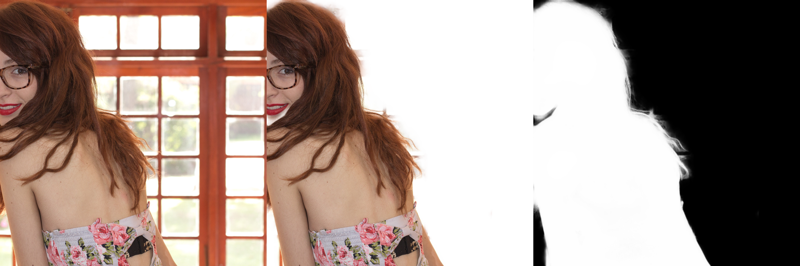

In [9]:
inferer = InfernceIMG(device='cpu')

matte =  inferer.transform(model, original_image)

combined, foreground  = inferer.combine(matte, original_image)

combined

In [101]:
def test_time(model, n=100, batch_size=1, prof=False):

    time_total = np.zeros(shape=n)
    # run inference
    batch = torch.rand(batch_size,3,512,512)
    for i in range(n):
        start = time()
        with torch.no_grad():
            output = model(batch, True)
        end = time()
        time_total[i] = end - start
        if not prof is False:
            prof.step()
        
    print(f'execution time for model is: {time_total.mean():.4f} +/- {time_total.std():.4f}')

In [25]:
test_time(model, n=100)

execution time for model is: 0.3277 +/- 0.0310


In [19]:
class Qmodel(nn.Module):
    def __init__(self, base, q = False):
        # By turning on Q we can turn on/off the quantization
        super(Qmodel, self).__init__()
        self.q = q
        self.base = base
        if q:
          self.quant = QuantStub()
          self.dequant = DeQuantStub()

    def forward(self, x: torch.Tensor, inference) -> torch.Tensor:
        if self.q:
          x = self.quant(x)
          
          o1, o2, matte = self.base(x, inference)
        
        if self.q:
          matte = self.dequant(matte)
        return o1,o2, matte

In [20]:
from torch.ao.quantization import get_default_qconfig_mapping
from torch.ao.quantization import QConfigMapping
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx
from torch.quantization.observer import MovingAverageMinMaxObserver

base = MODNet(backbone_pretrained=False)
base.load_state_dict(weights)

qmodel = Qmodel(base, q=True)
qmodel.eval()


qmodel.qconfig =  torch.ao.quantization.get_default_qconfig('fbgemm')

prepared_model = torch.ao.quantization.prepare(qmodel, inplace=False)

In [21]:
matte =  inferer.transform(prepared_model, original_image)

prepared_model

Image Size:  torch.Size([1, 3, 512, 512])


Qmodel(
  (base): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(
              3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
              (activation_post_process): HistogramObserver(min_val=-5.468085289001465, max_val=5.184305191040039)
            )
            (1): BatchNorm2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (activation_post_process): HistogramObserver(min_val=-1.7860194444656372, max_val=3.3615028858184814)
            )
            (2): ReLU6(
              inplace=True
              (activation_post_process): HistogramObserver(min_val=0.0, max_val=3.3615028858184814)
            )
          )
          (1): InvertedResidual(
            (ff): FloatFunctional(
              (activation_post_process): HistogramObserver(min_val=inf, max_val=-inf)
            )
            (conv): Sequenti

In [22]:
qmodel_int8 = torch.ao.quantization.convert(prepared_model)
print(qmodel_int8)

Qmodel(
  (base): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): QuantizedConv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), scale=0.0783071219921112, zero_point=65, padding=(1, 1), bias=False)
            (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): QuantizedReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (ff): QFunctional(
              scale=1.0, zero_point=0
              (activation_post_process): Identity()
            )
            (conv): Sequential(
              (0): QuantizedConv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.07791822403669357, zero_point=64, padding=(1, 1), groups=32, bias=False)
              (1): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): QuantizedReLU6(inplace=True)
              (3): Quantize

In [106]:
from torch.profiler import profile, record_function, ProfilerActivity

from torch.profiler import schedule

my_schedule = schedule(
    skip_first=10,
    wait=1,
    warmup=1,
    active=2,
    repeat=2)


with profile(activities=[ProfilerActivity.CPU],schedule=my_schedule, profile_memory=True) as prof:
    with record_function("model_inference"):
        test_time(model, n=100, batch_size=1,prof=prof)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2025-01-05 19:11:32 364824:364824 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-01-05 19:11:32 364824:364824 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-01-05 19:11:32 364824:364824 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-01-05 19:11:33 364824:364824 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-01-05 19:11:34 364824:364824 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-01-05 19:11:34 364824:364824 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


execution time for model is: 0.3451 +/- 0.0329
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                            Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
--------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
        aten::mkldnn_convolution        55.53%     346.372ms        56.02%     349.416ms       2.532ms     453.94 Mb       1.69 Mb           138  
         aten::native_batch_norm        18.53%     115.569ms        18.99%     118.459ms     705.113us     452.20 Mb      -3.29 Mb           168  
       aten::upsample_bilinear2d         7.77%      48.436ms         8.67%      54.056ms       3.003ms     118.88 Mb     102.51 Mb            18  
                       aten::cat         7.32%      45.667ms         7.

In [30]:
compiled = torch.compile(qmodel_int8)

In [31]:
test_time(compiled, n=100, batch_size=1)

[2025-01-05 15:52:34,623] [1/0] torch._dynamo.utils: [WARNING] Unsupported: quantized nyi in meta tensors with fake tensor propagation.
[2025-01-05 15:52:34,639] [2/0] torch._dynamo.utils: [WARNING] Unsupported: quantized nyi in meta tensors with fake tensor propagation.
[2025-01-05 15:52:34,653] [3/0] torch._dynamo.utils: [WARNING] Unsupported: quantized nyi in meta tensors with fake tensor propagation.
[2025-01-05 15:52:34,677] [4/0] torch._dynamo.utils: [WARNING] Unsupported: quantized nyi in meta tensors with fake tensor propagation.
[2025-01-05 15:52:34,726] [8/0] torch._dynamo.utils: [WARNING] Unsupported: quantized nyi in meta tensors with fake tensor propagation.
[2025-01-05 15:52:34,756] [10/0] torch._dynamo.utils: [WARNING] Unsupported: quantized nyi in meta tensors with fake tensor propagation.
[2025-01-05 15:52:34,832] [11/0] torch._dynamo.utils: [WARNING] Unsupported: quantized nyi in meta tensors with fake tensor propagation.
[2025-01-05 15:52:34,865] [12/0] torch._dynamo

execution time for model is: 0.3022 +/- 0.0694


In [32]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        test_time(compiled, n=100, batch_size=4)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2025-01-05 15:53:30 352088:352088 ActivityProfilerController.cpp:312] Completed Stage: Warm Up


execution time for model is: 1.3706 +/- 0.1918


STAGE:2025-01-05 15:55:48 352088:352088 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-01-05 15:55:48 352088:352088 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                              Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
--------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                 quantized::conv2d        34.75%       47.643s        40.44%       55.450s       8.036ms          6900  
                                         aten::cat        15.59%       21.381s        40.26%       55.200s      12.546ms          4400  
                         aten::upsample_bilinear2d        15.43%       21.157s        15.45%       21.176s      23.399ms           905  
                                       aten::clone        12.90%       17.685s        13.03%       17.870s       2.836ms          6302  
-----------------------------------------

In [107]:
from torch.profiler import profile, record_function, ProfilerActivity

from torch.profiler import schedule

my_schedule = schedule(
    skip_first=10,
    wait=1,
    warmup=1,
    active=2,
    repeat=2)

with profile(activities=[ProfilerActivity.CPU],schedule=my_schedule, profile_memory=True) as prof:
    with record_function("model_inference"):
        test_time(qmodel_int8, n=100, batch_size=1,prof=prof)

print(prof.key_averages(group_by_stack_n=5).table(sort_by="self_cpu_time_total", row_limit=4))

STAGE:2025-01-05 19:12:27 364824:364824 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-01-05 19:12:27 364824:364824 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-01-05 19:12:27 364824:364824 ActivityProfilerController.cpp:322] Completed Stage: Post Processing
STAGE:2025-01-05 19:12:28 364824:364824 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2025-01-05 19:12:28 364824:364824 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2025-01-05 19:12:28 364824:364824 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


execution time for model is: 0.2845 +/- 0.0281
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                quantized::conv2d        34.30%     180.037ms        40.10%     210.458ms       1.525ms     114.98 Mb    -522.41 Mb           138  
        aten::upsample_bilinear2d        15.77%      82.780ms        15.86%      83.249ms       4.625ms      29.72 Mb           0 b            18  
                        aten::cat        11.70%      61.387ms        35.55%     186.596ms       2.120ms     447.03 Mb    -357.62 Mb            88  
                      aten::clone         9.92%      52.073ms    

In [108]:
prof_results = prof.key_averages()
df = pd.DataFrame(map(vars, prof_results))
df = df.set_index('key')

In [109]:
df.head()

,count,node_id,is_async,is_remote,use_device,cpu_time_total,cuda_time_total,privateuse1_time_total,self_cpu_time_total,self_cuda_time_total,...,cuda_memory_usage,privateuse1_memory_usage,self_cpu_memory_usage,self_cuda_memory_usage,self_privateuse1_memory_usage,cpu_children,cpu_parent,device_type,is_legacy,flops
key,,,,,,,,,,,,,,,,,,,,,
ProfilerStep*,2,-1,False,False,None,524886,0,0,25899,0,...,0,0,-425938592,0,0,[<FunctionEvent id=1631746 name=aten::item dev...,None,DeviceType.CPU,False,0
aten::item,340,-1,False,False,None,1205,0,0,1034,0,...,0,0,0,0,0,[<FunctionEvent id=1631747 name=aten::_local_s...,<FunctionEvent id=1631745 name=ProfilerStep* d...,DeviceType.CPU,False,0
aten::_local_scalar_dense,340,-1,False,False,None,202,0,0,202,0,...,0,0,0,0,0,[],<FunctionEvent id=1631746 name=aten::item devi...,DeviceType.CPU,False,0
aten::quantize_per_tensor,46,-1,False,False,None,24610,0,0,24610,0,...,0,0,95322112,0,0,[],<FunctionEvent id=1631745 name=ProfilerStep* d...,DeviceType.CPU,False,0
quantized::conv2d,138,-1,False,False,None,210458,0,0,180037,0,...,0,0,-547782656,0,0,[<FunctionEvent id=1631752 name=aten::contiguo...,<FunctionEvent id=1631745 name=ProfilerStep* d...,DeviceType.CPU,False,0


In [63]:
df.columns

Index(['count', 'node_id', 'is_async', 'is_remote', 'use_device',
       'cpu_time_total', 'cuda_time_total', 'privateuse1_time_total',
       'self_cpu_time_total', 'self_cuda_time_total',
       'self_privateuse1_time_total', 'input_shapes', 'stack', 'scope',
       'cpu_memory_usage', 'cuda_memory_usage', 'privateuse1_memory_usage',
       'self_cpu_memory_usage', 'self_cuda_memory_usage',
       'self_privateuse1_memory_usage', 'cpu_children', 'cpu_parent',
       'device_type', 'is_legacy', 'flops'],
      dtype='object')

In [118]:
df['cpu_time_total'].iloc[0]/1e3

524.886

In [27]:
torch.save(qmodel_int8.state_dict(), 'MODNet/pretrained/q_model.ckpt')

Image Size:  torch.Size([1, 3, 512, 512])


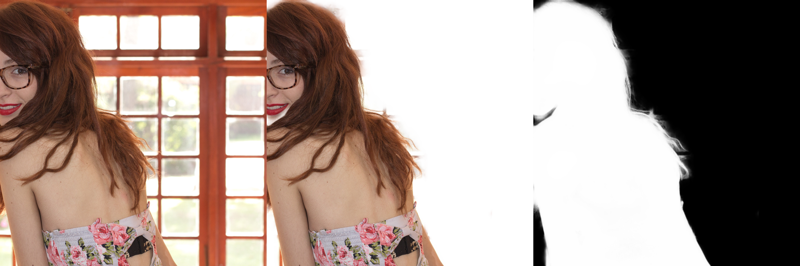

In [31]:
matte =  inferer.transform(model, original_image)

combined, foreground  = inferer.combine(matte, original_image)

combined

In [28]:
from validation import quality_validation, get_human_readable_size

In [29]:
metrics = quality_validation(qmodel_int8)

2025-01-05 18:21:11.365 | INFO     | validation:quality_validation:48 - Running performance validation MSE and JACCARD
355it [03:35,  1.65it/s]
2025-01-05 18:24:46.827 | SUCCESS  | validation:quality_validation:63 - Metrics were computed:{'MSE': 1751930.6422535211, 'JACCARD': 24880.123943661973}
